In [1]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from toolz import pipe

from pyrlmala.learning import LearningFactory
from pyrlmala.learning.callback import Callback
from pyrlmala.utils import Toolbox

In [2]:
plot_agent_500 = partial(Toolbox.plot_agent, steps_per_episode=500)

In [3]:
model_name = "banana"
stan_code_path = f"{model_name}.stan"
stan_data_path = f"{model_name}.json"

with open(stan_data_path, "r") as f:
    data = json.load(f)

    log_target_pdf = Toolbox.make_log_target_pdf(stan_code_path, data)
    grad_log_target_pdf = Toolbox.make_grad_log_target_pdf(stan_code_path, data)

/home/congye/Code/PythonProjects/pyrlmala/.venv/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /home/congye/Code/PythonProjects/pyrlmala/demo/banana/banana_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
  warnings.warn(


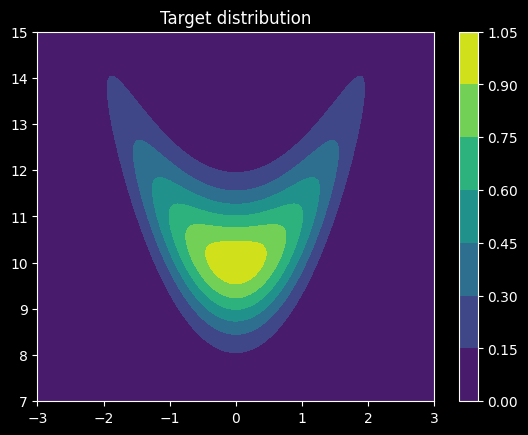

In [4]:
data_range = ((-3, 3, 100), (7, 15, 100))
Toolbox.target_plot(data_range, log_target_pdf)

In [5]:
sample_dim = 2
initial_sample = np.zeros(sample_dim)
initial_step_size = np.array([0.01])
algorithm = "ddpg"
runtime_config_path = "../../config/runtime.toml"

learning_instance = LearningFactory.create_learning_instance(
    algorithm=algorithm,
    log_target_pdf=log_target_pdf,
    grad_log_target_pdf=grad_log_target_pdf,
    initial_sample=initial_sample,
    initial_step_size=initial_step_size,
    hyperparameter_config_path=f"../../config/{algorithm}.toml",
    actor_config_path="../../config/actor.toml",
    critic_config_path="../../config/critic.toml",
)

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

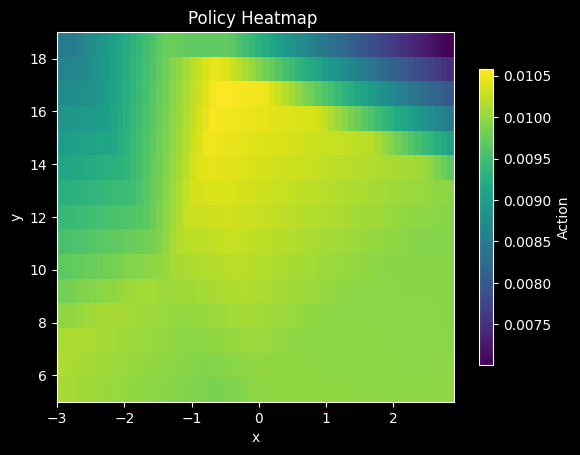

In [6]:
x_range = (-3,  3, 0.1)
y_range = ( 5, 20,   1)

policy = lambda x: learning_instance.actor(x.double())

Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

In [7]:
visualizer_and_actor_lr_instance = Callback(
    learning_instance,
    plot_frequency=100,
    num_of_mesh=10,
    auto_start=True,
    runtime_config_path=runtime_config_path,)

Callback observer started.


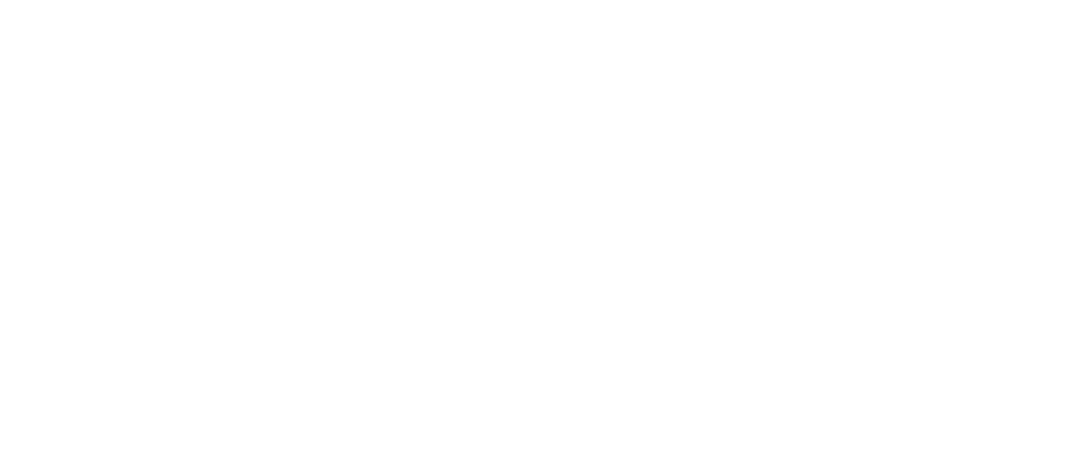

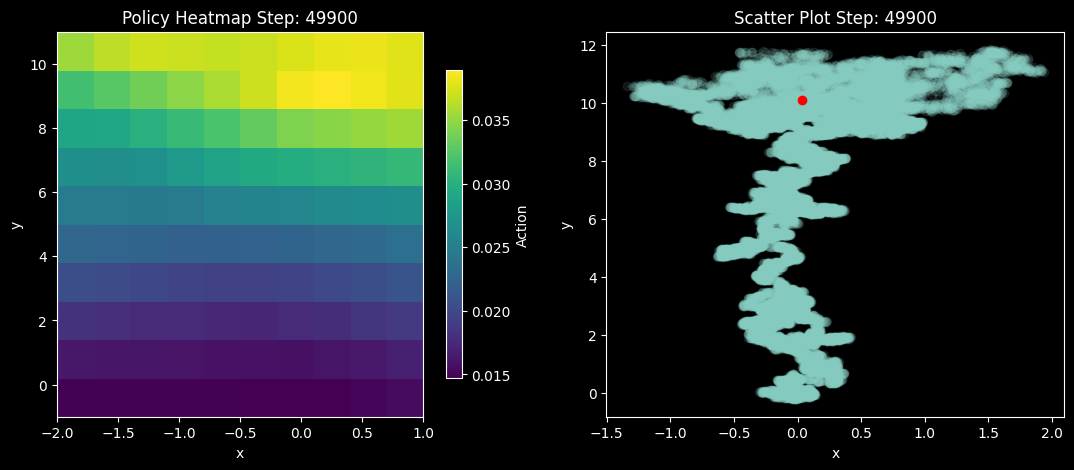

In [8]:
visualizer_and_actor_lr_instance.train()

In [ ]:
Toolbox.policy_plot_2D_heatmap(policy, torch.arange(*x_range), torch.arange(*y_range))

In [ ]:
lower_window_size = 0
upper_window_size = learning_instance.env.envs[0].get_wrapper_attr("current_step") - 1

reward_item_plot = lambda tpl: plt.plot(tpl[1][lower_window_size:upper_window_size], label=f"{tpl[0]}", alpha=0.5)

pipe(
    learning_instance.env.envs[0],
    lambda env: (
        ("transient", env.get_wrapper_attr("reward_items")["transient"]),
        ("entropy", env.get_wrapper_attr("reward_items")["entropy"]),
        ("esjd", env.get_wrapper_attr("reward_items")["expected_square_jump_distance"])
    ),
    lambda tpl: (reward_item_plot(tpl[0]), reward_item_plot(tpl[1]), reward_item_plot(tpl[2])),
    lambda _: plt.legend(),
    lambda _: plt.show()
)

In [ ]:
accepted_sample = pipe(
    learning_instance,
    lambda x: getattr(x, "env"),
    lambda x: x.get_attr("store_accepted_sample"),
)[0]

plt.plot(
    accepted_sample[lower_window_size:upper_window_size, 0],
    accepted_sample[lower_window_size:upper_window_size, 1],
    'o-', alpha=0.1)
plt.show()

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "critic_values"), plot_agent_500)

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "critic_loss"), plot_agent_500)

In [ ]:
pipe(learning_instance, lambda x: getattr(x, "actor_loss"), plot_agent_500)

In [ ]:
reward = pipe(
    learning_instance,
    lambda x: getattr(x, "env"),
    lambda x: x.get_attr("store_reward")[0],
    Toolbox.reward_plot
)